In [78]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
#import torch.utils.tensorboard as tb
from Preprocessing.preprocessing import PreprocessingTrainingData
from torch.utils.data.sampler import SequentialSampler, RandomSampler, SubsetRandomSampler
import seaborn as sns
import matplotlib.pyplot as  plt
import os
import logging
torch.set_printoptions(profile="full")
import pandas as pd

In [79]:
#static parameters
train_batch_size = 30
val_batch_size = 30
sequence_length=50
test_batch_size = 1
input_size = 1
hidden_size = 256
num_layer = 2
output_size = 38
clip = 3

In [80]:
#get data from preprocessing.py
dataset_path = os.path.join(os.path.abspath('..'),'Dataset\\Clementi dataset\\Clementi dataset' )
network_input,network_output,max_midi_number,min_midi_number,int_to_note = PreprocessingTrainingData().preprocess_notes(dataset_path)
network_input, network_output = network_input.cuda(), network_output.cuda()

# print(network_input)
#print(network_output)

In [81]:
# # Bakchodi Normalization
# network_input=network_input.cpu().numpy().tolist()
# for i in range(len(network_input)):
#     for j in range(len(network_input[i])):
#         network_input[i][j][0]=((network_input[i][j][0])*(max_midi_number-min_midi_number)+min_midi_number)/max_midi_number
# network_input=torch.Tensor(network_input).cuda()

In [82]:
#plt.plot(network_input[5].cpu())

In [83]:
print(network_output.max())
print(network_output.min())

tensor(37, device='cuda:0')
tensor(0, device='cuda:0')


In [84]:
#network_output

In [85]:
print(network_input.max())
print(network_input.min())
print(max_midi_number)
print(min_midi_number)
print(int_to_note)

tensor(1., device='cuda:0')
tensor(0.5618, device='cuda:0')
89
50
{0: 50, 1: 52, 2: 53, 3: 54, 4: 55, 5: 56, 6: 57, 7: 58, 8: 59, 9: 60, 10: 61, 11: 62, 12: 63, 13: 64, 14: 65, 15: 66, 16: 67, 17: 68, 18: 69, 19: 70, 20: 71, 21: 72, 22: 73, 23: 74, 24: 75, 25: 76, 26: 77, 27: 78, 28: 79, 29: 80, 30: 81, 31: 82, 32: 83, 33: 84, 34: 85, 35: 86, 36: 88, 37: 89}


In [86]:
'''
data is highly unbalanced
# '''
# sns.distplot(torch.tensor(network_output).cpu())
# xx = pd.DataFrame(torch.tensor(network_output).cpu())
# xx.groupby(0).size().to_frame(name='values')

'\ndata is highly unbalanced\n# '

In [87]:
'''
to make batch of equal sizes
Quick Fix
'''
network_input = network_input[: -29]
network_output = network_output[: -29]

print(network_input.shape)
print(network_output.shape)

torch.Size([8588, 50, 1])
torch.Size([8588])


In [25]:
#network_input[:10]

In [26]:
'''
create Stacked LSTM model
'''
class Stacked_LSTM(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, output_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm1 = nn.LSTM(input_size = input_size, hidden_size = hidden_size, batch_first = True)
        self.lstm2 = nn.LSTM(input_size = hidden_size, hidden_size = output_size,batch_first = True)
        
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(output_size, output_size)
        
        
    def forward(self, x, batch_size):
        
        output, _ = self.lstm1(x)        
        #print(output.shape)
        
        #output = self.dropout(output)
        
        output, _ = self.lstm2(output)
        #print(output.shape)
        
        # stack up lstm outputs
        output = output.contiguous().view(-1, 38)
        #print(output.shape)
        
        output = self.dropout(output)
        output = self.linear(output)
        #print('Linear Output :-',output.shape)
        
        #output = F.softmax(output, dim = 1)
        #print('SOFTMAX OUTPUT :--', output)
        
        
        # reshape to be batch_size first
        output = output.view(batch_size, -1)
        #print('Reshape to batch size first :-',output.shape)
        
        output = output[:, -self.output_size:] # get last batch of labels
        #print('Final Output :-',output)
        #print('RESHAPE SIZE :-', output.shape)
        
        return output

#initialize the weights of LSTM using Xavier initialization    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight) 

In [27]:
'''
Divide the dataset into train/val 
'''
train_size = 0.8
indices = list(range(len(network_input)))
split = int(np.floor(train_size*len(network_input)))
train_idx, val_idx = indices[:split], indices[split:]

train_sampler = SequentialSampler(train_idx)
#train_sampler = SubsetRandomSampler(train_idx)

val_sampler = SequentialSampler(val_idx)

dataset = TensorDataset(network_input,network_output)
train_loader = DataLoader(dataset, batch_size= train_batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size= val_batch_size,sampler= val_sampler)

In [28]:
import torch.optim as optimizer

model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optimizer.AdamW(model.parameters())
#optimizer = optimizer.RMSprop(model.parameters(), lr = 0.001, weight_decay = 0.01)


#make sure to transfer model to GPU after initializing optimizer
model.cuda()

Stacked_LSTM(
  (lstm1): LSTM(1, 256, batch_first=True)
  (lstm2): LSTM(256, 38, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=38, out_features=38, bias=True)
)

In [29]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)

In [16]:
epochs = 500
min_val_loss = np.Inf

validation_loss_list = []
training_loss_list = []
validation_accuracy_list = []
training_accuracy_list = []


for e in range(epochs):
    
    train_loss = 0
    val_loss = 0
    train_accuracy = 0
    val_accuracy = 0
    
    for inputs,labels in train_loader:
        #print(inputs.shape)

        '''
        Creating new variables for the hidden state, otherwise
        we'd backprop through the entire training history
        '''
        
        # zero accumulated gradients
        model.zero_grad()
       
        # get the output from the model
        output = model.forward(inputs, train_batch_size)
        #print('OUTPUT', output)
        
        
        #print('Labels Shape :-', (torch.max(labels, 1)[1]).shape)
    
        # calculate the loss and perform backprop
        #print('Labels Long :-', labels.long())
        loss = criterion(output,labels.long())
        #print('LOSS IS :-', loss)
        
        loss.backward()
        
        #calculate training accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        logging.debug(' top probab {} top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        equals = top_class == labels.long().view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        #nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        train_loss += loss.item()
        #print(train_loss)
              
    model.eval()
    for inputs, labels in val_loader:
                
        output = model.forward(inputs, val_batch_size)
       
        loss = criterion(output,labels.long())
        
        val_loss += loss.item()
        
        #calculate validation accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        
        #logging.debug(output)
        #logging.debug('VALIDATION top probab {} VALIDATION top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        #print('Top Class:- ',top_class)
        equals = top_class == labels.long().view(*top_class.shape)
        #print('Equals:- ', equals)
        val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    model.train()
    
    #Averaging losses
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    val_accuracy = val_accuracy/len(val_loader)
    train_accuracy = train_accuracy/len(train_loader)
    
    training_accuracy_list.append(train_accuracy)
    validation_loss_list.append(val_accuracy)
    training_loss_list.append(train_loss)
    validation_loss_list.append(val_loss)
    
    
    print('Epoch: {}\tTrain Loss: {:.7f} \tVal Loss:{:.7f} \tTrain Acc: {:.7}% \tVal Acc: {:.7f}%'.format(e, train_loss, val_loss, train_accuracy*100,val_accuracy*100))
    
    #saving the model if validation loss is decreased
    if val_loss <= min_val_loss:
        print('Validation Loss decreased from {:6f} to {:6f}, saving the model weights'.format(min_val_loss, val_loss))
        torch.save(model.state_dict(), 'lstm_state_256-38-dfasdfa.pt')
        min_val_loss = val_loss

Epoch: 0	Train Loss: 3.6430713 	Val Loss:3.3945597 	Train Acc: 4.444445% 	Val Acc: 1.6666667%
Validation Loss decreased from    inf to 3.394560, saving the model weights
Epoch: 1	Train Loss: 3.4642679 	Val Loss:3.3202124 	Train Acc: 4.652778% 	Val Acc: 1.6666667%
Validation Loss decreased from 3.394560 to 3.320212, saving the model weights
Epoch: 2	Train Loss: 3.4266632 	Val Loss:3.2255198 	Train Acc: 3.680556% 	Val Acc: 8.8888892%
Validation Loss decreased from 3.320212 to 3.225520, saving the model weights
Epoch: 3	Train Loss: 3.3746932 	Val Loss:3.1981152 	Train Acc: 4.236111% 	Val Acc: 8.8888892%
Validation Loss decreased from 3.225520 to 3.198115, saving the model weights
Epoch: 4	Train Loss: 3.3618637 	Val Loss:3.1795826 	Train Acc: 4.583334% 	Val Acc: 8.8888892%
Validation Loss decreased from 3.198115 to 3.179583, saving the model weights
Epoch: 5	Train Loss: 3.3523779 	Val Loss:3.1733046 	Train Acc: 4.097222% 	Val Acc: 8.8888892%
Validation Loss decreased from 3.179583 to 3.173

Epoch: 59	Train Loss: 2.5125024 	Val Loss:2.3376627 	Train Acc: 20.48611% 	Val Acc: 25.0000004%
Epoch: 60	Train Loss: 2.4909838 	Val Loss:2.2980911 	Train Acc: 20.55556% 	Val Acc: 26.6666672%
Validation Loss decreased from 2.323928 to 2.298091, saving the model weights
Epoch: 61	Train Loss: 2.4539886 	Val Loss:2.2887727 	Train Acc: 22.08333% 	Val Acc: 27.7777781%
Validation Loss decreased from 2.298091 to 2.288773, saving the model weights
Epoch: 62	Train Loss: 2.4785355 	Val Loss:2.2936778 	Train Acc: 21.52778% 	Val Acc: 27.2222230%
Epoch: 63	Train Loss: 2.4600914 	Val Loss:2.2794977 	Train Acc: 22.84722% 	Val Acc: 30.0000007%
Validation Loss decreased from 2.288773 to 2.279498, saving the model weights
Epoch: 64	Train Loss: 2.4304314 	Val Loss:2.2465364 	Train Acc: 21.38889% 	Val Acc: 32.7777783%
Validation Loss decreased from 2.279498 to 2.246536, saving the model weights
Epoch: 65	Train Loss: 2.4317674 	Val Loss:2.2576148 	Train Acc: 21.73611% 	Val Acc: 28.6111116%
Epoch: 66	Train 

Epoch: 119	Train Loss: 1.5646090 	Val Loss:1.4874013 	Train Acc: 49.79167% 	Val Acc: 56.1111117%
Epoch: 120	Train Loss: 1.6282017 	Val Loss:1.2328790 	Train Acc: 51.04167% 	Val Acc: 64.1666663%
Epoch: 121	Train Loss: 1.5157144 	Val Loss:1.1530932 	Train Acc: 50.625% 	Val Acc: 68.3333330%
Validation Loss decreased from 1.227678 to 1.153093, saving the model weights
Epoch: 122	Train Loss: 1.5074741 	Val Loss:1.0810529 	Train Acc: 50.76389% 	Val Acc: 73.0555552%
Validation Loss decreased from 1.153093 to 1.081053, saving the model weights
Epoch: 123	Train Loss: 1.4917896 	Val Loss:1.1301099 	Train Acc: 51.875% 	Val Acc: 67.2222232%
Epoch: 124	Train Loss: 1.4721610 	Val Loss:1.1331618 	Train Acc: 53.26389% 	Val Acc: 70.5555553%
Epoch: 125	Train Loss: 1.4526111 	Val Loss:1.0511431 	Train Acc: 55.06945% 	Val Acc: 71.9444444%
Validation Loss decreased from 1.081053 to 1.051143, saving the model weights
Epoch: 126	Train Loss: 1.4324968 	Val Loss:1.0686698 	Train Acc: 56.38889% 	Val Acc: 72.222

Epoch: 184	Train Loss: 0.4964865 	Val Loss:0.2461517 	Train Acc: 87.98611% 	Val Acc: 94.7222218%
Epoch: 185	Train Loss: 0.4763379 	Val Loss:0.2388597 	Train Acc: 87.5% 	Val Acc: 94.7222218%
Validation Loss decreased from 0.245921 to 0.238860, saving the model weights
Epoch: 186	Train Loss: 0.4618872 	Val Loss:0.2113090 	Train Acc: 88.40278% 	Val Acc: 96.1111108%
Validation Loss decreased from 0.238860 to 0.211309, saving the model weights
Epoch: 187	Train Loss: 0.4542499 	Val Loss:0.2168701 	Train Acc: 89.23611% 	Val Acc: 95.2777768%
Epoch: 188	Train Loss: 0.4488484 	Val Loss:0.2042035 	Train Acc: 89.44444% 	Val Acc: 96.6666664%
Validation Loss decreased from 0.211309 to 0.204204, saving the model weights
Epoch: 189	Train Loss: 0.4130550 	Val Loss:0.1956923 	Train Acc: 90.41667% 	Val Acc: 96.3888889%
Validation Loss decreased from 0.204204 to 0.195692, saving the model weights
Epoch: 190	Train Loss: 0.4086022 	Val Loss:0.1847877 	Train Acc: 89.93055% 	Val Acc: 96.1111103%
Validation Lo

Epoch: 251	Train Loss: 0.1644331 	Val Loss:0.0581344 	Train Acc: 96.45833% 	Val Acc: 98.6111104%
Validation Loss decreased from 0.063265 to 0.058134, saving the model weights
Epoch: 252	Train Loss: 0.1682769 	Val Loss:0.0548598 	Train Acc: 96.80555% 	Val Acc: 98.8888885%
Validation Loss decreased from 0.058134 to 0.054860, saving the model weights
Epoch: 253	Train Loss: 0.1525299 	Val Loss:0.0545785 	Train Acc: 96.94444% 	Val Acc: 98.6111109%
Validation Loss decreased from 0.054860 to 0.054578, saving the model weights
Epoch: 254	Train Loss: 0.1521680 	Val Loss:0.0574075 	Train Acc: 96.45833% 	Val Acc: 98.3333334%
Epoch: 255	Train Loss: 0.1380273 	Val Loss:0.0486510 	Train Acc: 97.56944% 	Val Acc: 98.8888890%
Validation Loss decreased from 0.054578 to 0.048651, saving the model weights
Epoch: 256	Train Loss: 0.1486556 	Val Loss:0.0444484 	Train Acc: 97.22222% 	Val Acc: 98.8888890%
Validation Loss decreased from 0.048651 to 0.044448, saving the model weights
Epoch: 257	Train Loss: 0.136

Epoch: 323	Train Loss: 0.1588136 	Val Loss:0.0535082 	Train Acc: 95.69444% 	Val Acc: 98.0555554%
Epoch: 324	Train Loss: 0.1321565 	Val Loss:0.0407399 	Train Acc: 96.94444% 	Val Acc: 98.6111104%
Epoch: 325	Train Loss: 0.1188591 	Val Loss:0.0435844 	Train Acc: 97.29167% 	Val Acc: 98.0555554%
Epoch: 326	Train Loss: 0.1098019 	Val Loss:0.0352633 	Train Acc: 97.5% 	Val Acc: 98.6111109%
Epoch: 327	Train Loss: 0.0986774 	Val Loss:0.0343882 	Train Acc: 97.77778% 	Val Acc: 98.8888890%
Epoch: 328	Train Loss: 0.0925222 	Val Loss:0.0292516 	Train Acc: 98.19444% 	Val Acc: 98.6111109%
Epoch: 329	Train Loss: 0.0927986 	Val Loss:0.0272581 	Train Acc: 98.40278% 	Val Acc: 99.1666665%
Validation Loss decreased from 0.027586 to 0.027258, saving the model weights
Epoch: 330	Train Loss: 0.0884893 	Val Loss:0.0291005 	Train Acc: 98.68055% 	Val Acc: 98.8888885%
Epoch: 331	Train Loss: 0.0833693 	Val Loss:0.0290310 	Train Acc: 98.54167% 	Val Acc: 98.8888885%
Epoch: 332	Train Loss: 0.0894250 	Val Loss:0.0250483 

Epoch: 401	Train Loss: 0.1403635 	Val Loss:0.0239153 	Train Acc: 96.25% 	Val Acc: 99.1666660%
Epoch: 402	Train Loss: 0.2401161 	Val Loss:0.0876377 	Train Acc: 92.91667% 	Val Acc: 96.9444434%
Epoch: 403	Train Loss: 0.3963280 	Val Loss:0.1816821 	Train Acc: 87.91667% 	Val Acc: 93.8888878%
Epoch: 404	Train Loss: 0.4116442 	Val Loss:0.3031632 	Train Acc: 87.5% 	Val Acc: 92.2222217%
Epoch: 405	Train Loss: 0.2754176 	Val Loss:0.0908681 	Train Acc: 91.52778% 	Val Acc: 96.9444439%
Epoch: 406	Train Loss: 0.1545461 	Val Loss:0.0676511 	Train Acc: 95.76389% 	Val Acc: 97.7777779%
Epoch: 407	Train Loss: 0.1812931 	Val Loss:0.0305880 	Train Acc: 94.86111% 	Val Acc: 99.1666665%
Epoch: 408	Train Loss: 0.1788141 	Val Loss:0.0316453 	Train Acc: 95.76389% 	Val Acc: 98.8888885%
Epoch: 409	Train Loss: 0.1063177 	Val Loss:0.0341183 	Train Acc: 97.22222% 	Val Acc: 98.6111109%
Epoch: 410	Train Loss: 0.0795681 	Val Loss:0.0247866 	Train Acc: 98.33333% 	Val Acc: 98.6111109%
Epoch: 411	Train Loss: 0.0719681 	Val

Epoch: 481	Train Loss: 0.0388843 	Val Loss:0.0351639 	Train Acc: 99.16667% 	Val Acc: 98.6111109%
Epoch: 482	Train Loss: 0.0431653 	Val Loss:0.0255084 	Train Acc: 98.95833% 	Val Acc: 99.4444440%
Epoch: 483	Train Loss: 0.0368745 	Val Loss:0.0257577 	Train Acc: 99.09722% 	Val Acc: 98.6111109%
Epoch: 484	Train Loss: 0.0362247 	Val Loss:0.0185534 	Train Acc: 99.02778% 	Val Acc: 99.1666660%
Epoch: 485	Train Loss: 0.0364083 	Val Loss:0.0288249 	Train Acc: 99.30556% 	Val Acc: 98.8888890%
Epoch: 486	Train Loss: 0.0396255 	Val Loss:0.0388720 	Train Acc: 98.95833% 	Val Acc: 98.6111109%
Epoch: 487	Train Loss: 0.0438628 	Val Loss:0.0689483 	Train Acc: 99.16667% 	Val Acc: 97.7777774%
Epoch: 488	Train Loss: 0.0656563 	Val Loss:0.0296562 	Train Acc: 98.33333% 	Val Acc: 99.1666665%
Epoch: 489	Train Loss: 0.0479540 	Val Loss:0.0161210 	Train Acc: 98.81944% 	Val Acc: 99.4444445%
Epoch: 490	Train Loss: 0.0464227 	Val Loss:0.0139012 	Train Acc: 98.68056% 	Val Acc: 99.7222220%
Validation Loss decreased from

## MUSIC GENERATION

In [65]:
#load weights
test_model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
test_model.load_state_dict(torch.load('checkpoints/lstm_state_256-38-bak_norm.pt'))
test_model.eval()
test_model.cuda()

Stacked_LSTM(
  (lstm1): LSTM(1, 256, batch_first=True)
  (lstm2): LSTM(256, 38, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=38, out_features=38, bias=True)
)

In [66]:
from Preprocessing import postprocessing_normalization_function
testing_data = postprocessing_normalization_function.normalize('..\\Dataset\\Test_Data\\trading.csv', min_midi_number, max_midi_number)

In [67]:
#testing_data

In [68]:
testing_data = np.asarray(testing_data)
testing_data = testing_data.reshape(testing_data.shape[0],1)
# Bakchodi Normalization
for i in range(len(testing_data)):
    for j in range(len(testing_data[i])):
        testing_data[i][j]=((testing_data[i][j])*(max_midi_number-min_midi_number)+min_midi_number)/max_midi_number

In [69]:
#testing_data

In [70]:
#load population database
#testing_data = np.ones(200)
# testing_data = list(range(50,90))
# testing_data.extend(testing_data[::-1])
# testing_data_rev = testing_data[::-1]
# testing_data_rev.extend(testing_data)
# testing_data_rev.extend(testing_data_rev)
# testing_data = testing_data_rev


# testing_data = np.asarray(testing_data)
# testing_data = testing_data.reshape(testing_data.shape[0],1)

initial_seq = [network_input[0][1:].cpu().numpy().tolist()]

testing_data_unnorm = testing_data

In [58]:
#sns.distplot((network_input[0][1:]*89).cpu().reshape(-1))

In [59]:
list1=[]
testing_data=testing_data.tolist()
for i in range(len(testing_data)):
    list1.extend(testing_data[i])

#list1

for i in range(len(list1)):
    #list1[i]=(list1[i]-50)/(89-50)
    list1[i]=(list1[i])/(89)

list1 = np.asarray(list1)
list1 = list1.reshape(list1.shape[0],1)
testing_data = list1
#list1

In [60]:
#testing_data

In [71]:
#Predicting
def prediction_with_influence(influence,int2note,initial_seq, max_note, min_note,test_batch_size = 1):

    predicted_notes = []
    initial_seq[0].extend([[0]]*len(testing_data))
    test_seq = torch.Tensor(initial_seq).cuda()
    
    for i in range(len(influence)):
        
        test_seq[0][sequence_length - 1 + i][0] = float(influence[i])
        
        test_slice = test_seq[0][i : i + sequence_length]        
        test_slice = test_slice.view(1, test_slice.shape[0], test_slice.shape[1])
        
        test_output = test_model.forward(test_slice, test_batch_size)
    
        test_output = F.softmax(test_output, dim = 1)
        top_p, top_class = test_output.topk(1,dim =1)
        
#         test_seq[0][sequence_length - 1 + i][0] = (int2note[top_class.item()] - min_note)/(max_note - min_note)
        test_seq[0][sequence_length - 1 + i][0] = int2note[top_class.item()]/max_note
        
        predicted_notes.append(int2note[top_class.item()])
        
    return predicted_notes

In [72]:
predicted_notes_lst = prediction_with_influence(testing_data,int_to_note,initial_seq, max_midi_number, min_midi_number)

In [73]:
#predicted_notes_lst

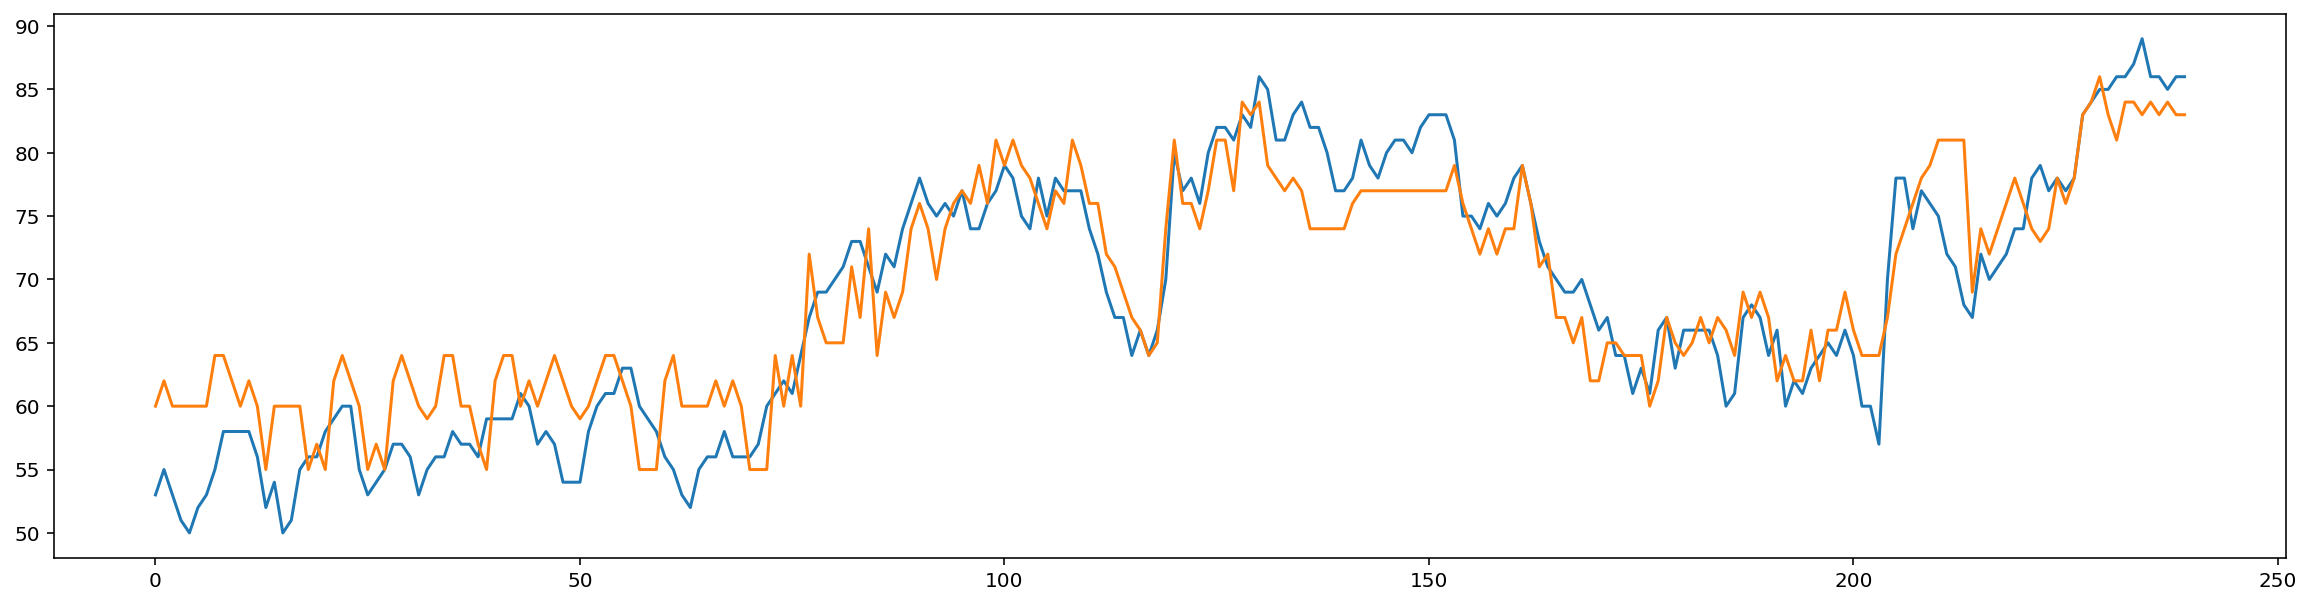

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
#plt.plot(list(np.ones(200)*89))

#plt.plot(list(np.ones(200)*53))
#plt.plot(list(np.ones(20)*50))
plt.plot(testing_data_unnorm*89)
plt.plot(predicted_notes_lst)

In [24]:
from collections import Counter
c = Counter(predicted_notes_lst)
c

Counter({60: 31,
         62: 23,
         64: 25,
         55: 12,
         57: 3,
         59: 2,
         72: 7,
         67: 13,
         65: 10,
         71: 3,
         74: 21,
         69: 7,
         76: 17,
         70: 1,
         77: 17,
         79: 8,
         81: 11,
         78: 7,
         66: 6,
         84: 7,
         83: 7,
         73: 1,
         86: 1})

In [86]:
from Postprocessing.postprocessing import PostProcessing
PostProcessing().generate_midi_file('hello.midi', predicted_notes_lst)

In [ ]:
#int_to_note